Import the Python Libraries used in the analysis

In [1]:
from pathlib import Path

import pandas as pd
from pandas import read_csv
import numpy as np

import matplotlib.pyplot as plt

from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter

from datetime import datetime
from datetime import  timedelta

from dateutil import parser #date parsing function

#random generator used in nulltests
import random

#correlation used in nulltest results, and similar sites creation
import scipy.stats
from scipy import stats
from scipy.stats import pearsonr


def parse_date(date_str):
    try:
        return parser.parse(date_str, dayfirst=True)
    except ValueError:
        # Handle cases where parsing fails
        return pd.NaT


Importing the dataset.  The data is sourced from Kaggle.

https://www.kaggle.com/datasets/mathchi/online-retail-ii-data-set-from-ml-repository

In [2]:
#import the dataset.  It is in two parts.  
dataset_retail = read_csv("/Users/jeffreycampbell/Desktop/python_work/customer_loyalty/online_retail_II_09_10.csv")
dataset_retail_2 = read_csv("/Users/jeffreycampbell/Desktop/python_work/customer_loyalty/online_retail_I_10_11.csv")

#bring the two dataframes together
dataset_retail = pd.concat([dataset_retail, dataset_retail_2], ignore_index=True)

#change dates to date format
dataset_retail['InvoiceDate'] = pd.to_datetime(dataset_retail['InvoiceDate'], format='mixed')

#there is a quantity and price column, but not a sales line.  Create the sales metric by multiplying price and quantity
dataset_retail['SKU_sales'] = dataset_retail['Quantity'] * dataset_retail['Price']


Data starts as SKU level purchase data, with multiple rows per transaction.  Group and sum by transaction ID for sales/ trx.

In [3]:
#each SKU in a transaction is a multiple row.  I want to combine SKU sales to total sales for the transaction.  
#I need the sales, date, and customer id columns

trx_summed = dataset_retail.groupby('Invoice')['SKU_sales'].sum().reset_index()
trx_date = dataset_retail.groupby('Invoice')['InvoiceDate'].min().reset_index()
trx_cust = dataset_retail.groupby('Invoice')['Customer ID'].min().reset_index()

#merge the columns into a single dataframe
trx_summed = trx_summed.merge(trx_date, on='Invoice')
trx_summed = trx_summed.merge(trx_cust, on='Invoice')

#cast sales as a float type
trx_summed['SKU_sales'] = trx_summed['SKU_sales'].astype(float)

#pull descriptive stats
stdev_index = trx_summed['SKU_sales'].std()
mean = trx_summed['SKU_sales'].mean()



Understanding the distribution of transaction size via histogram.  Also flagging outliers that are +- 3 standard devs from the mean.  
Note that outliers extend out to $150K transaction size, where the lowest outlier level (mean + 3 standard deviations) is $5.3K.  
There are also many negative transactions

stdev of data 1654.8292884069403


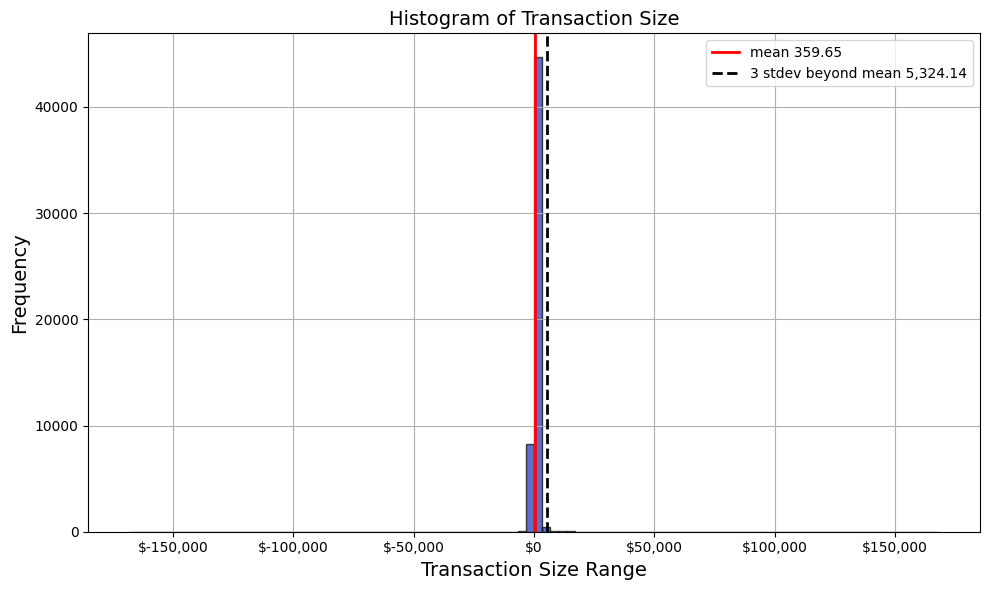

In [4]:
#understanding the distribution of transaction size via histogram.  Also flagging outliers that are +- 3 standard devs from the mean

stdev_index = trx_summed['SKU_sales'].std()
print(f"stdev of data {stdev_index}")
mean = trx_summed['SKU_sales'].mean()

# Plotting the histogram of trx size
plt.figure(figsize=(10, 6))
plt.hist(trx_summed['SKU_sales'], bins=100, color=(0.1, 0.2, 0.7, 0.6), edgecolor='black', alpha=0.7)
plt.axvline(mean, color='red', linewidth=2, label=f'mean {mean:,.2f}')
plt.axvline(stdev_index*3+mean, color='black', linestyle = '--',linewidth=2, label=f'3 stdev beyond mean {stdev_index*3+mean:,.2f}')
plt.title("Histogram of Transaction Size", fontsize=14)
plt.xlabel("Transaction Size Range", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.grid(True)

# Format the x-axis to show dollar signs and avoid scientific notation
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

Capping transaction size to reduce the influence of outliers.  Outlier transactions are brought down to the mean + 3 standard deviations.

In [5]:
#stdev and mean of the dataset
stdev_index = trx_summed['SKU_sales'].std()
mean = trx_summed['SKU_sales'].mean()

print(f"stdev: ${stdev_index:,.0f}, mean: ${mean:,.0f}")

#trx count, sum of sales, max trx size before outlier capping
print(f"count of trx pre cap: {trx_summed['SKU_sales'].count()}")
print(f"sum of sales pre cap: ${trx_summed['SKU_sales'].sum():,.0f}")
print(f"max trans size pre cap: ${trx_summed['SKU_sales'].max():,.0f}")

#outlier capping
outlier_capped_trx_data = trx_summed.copy()
outlier_capped_trx_data.loc[outlier_capped_trx_data['SKU_sales'] > mean + stdev_index*3, 'SKU_sales'] = mean + stdev_index*3
outlier_capped_trx_data.loc[outlier_capped_trx_data['SKU_sales'] < mean - stdev_index*3, 'SKU_sales'] = mean - stdev_index*3

#trx count, sum of sales, max trx size after outlier capping
print(f"count of trx post cap: {outlier_capped_trx_data['SKU_sales'].count()}")
print(f"sum of sales post cap: ${outlier_capped_trx_data['SKU_sales'].sum():,.0f}")
print(f"max trans size post cap: ${outlier_capped_trx_data['SKU_sales'].max():,.0f}")

#standard dev and mean after capping
stdev_index_cap = outlier_capped_trx_data['SKU_sales'].std()
mean_cap = outlier_capped_trx_data['SKU_sales'].mean()

print(f"stdev: ${stdev_index_cap:,.0f}, mean: ${mean_cap:,.0f}")

print(f"percent of sales that are outliers: {(trx_summed['SKU_sales'].sum() - outlier_capped_trx_data['SKU_sales'].sum()) / trx_summed['SKU_sales'].sum() * 100:,.1f}%")

stdev: $1,655, mean: $360
count of trx pre cap: 53628
sum of sales pre cap: $19,287,251
max trans size pre cap: $168,470
count of trx post cap: 53628
sum of sales post cap: $18,231,386
max trans size post cap: $5,324
stdev: $682, mean: $340
percent of sales that are outliers: 5.5%


Histogram of tranaction size after outlier capping.  Note the spike at $5.3K where outliers were capped

stdev of data 681.8970168943576


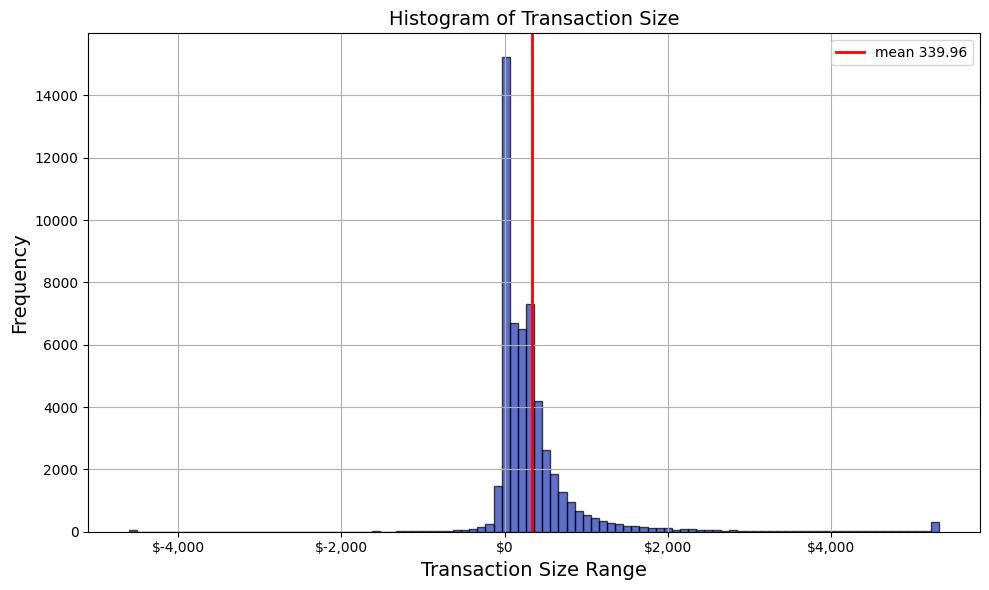

In [6]:
stdev_index = outlier_capped_trx_data['SKU_sales'].std()
print(f"stdev of data {stdev_index}")
mean = outlier_capped_trx_data['SKU_sales'].mean()

# Plotting the histogram of trx size
plt.figure(figsize=(10, 6))
plt.hist(outlier_capped_trx_data['SKU_sales'], bins=100, color=(0.1, 0.2, 0.7, 0.6), edgecolor='black', alpha=0.7)
plt.axvline(mean, color='red', linewidth=2, label=f'mean {mean:,.2f}')
#plt.axvline(stdev_index*3+mean, color='black', linestyle = '--',linewidth=2, label=f'3 stdev beyond mean {stdev_index*3+mean:,.2f}')
plt.title("Histogram of Transaction Size", fontsize=14)
plt.xlabel("Transaction Size Range", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.grid(True)

# Format the x-axis to show dollar signs and avoid scientific notation
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

Histogram of transactions per customer.  Looking for customers with outlying frequency of shop.  Outlying sales are 55+ transactions.

510


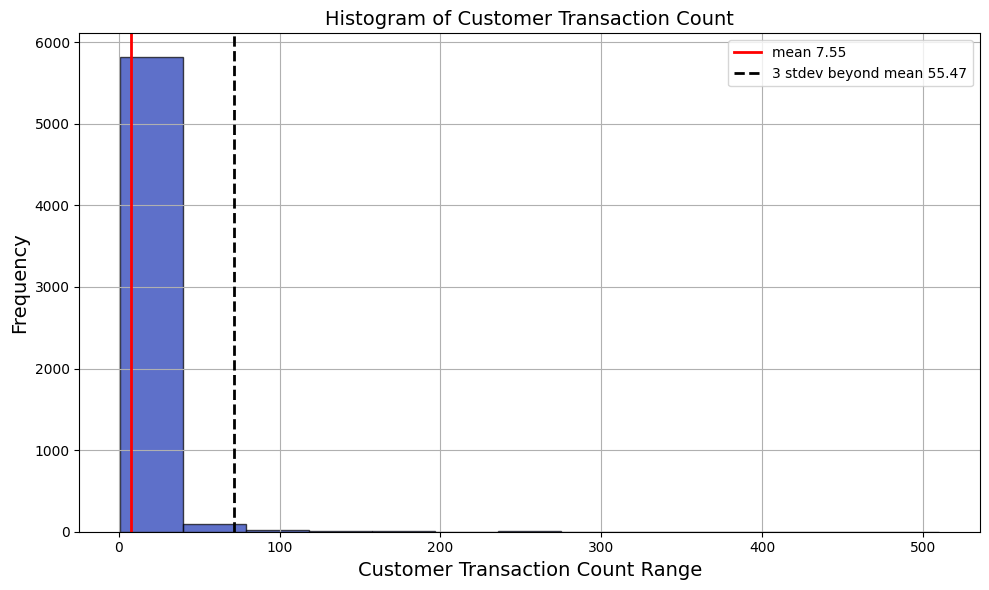

In [7]:
#cust trx counts
customer_sales = outlier_capped_trx_data.groupby('Customer ID')['Invoice'].count().reset_index()
customer_sales.columns = ['Customer ID', 'Invoice_Count']
stdev_index = customer_sales['Invoice_Count'].std()
mean = customer_sales['Invoice_Count'].mean()
print(customer_sales['Invoice_Count'].max())

# Plotting the histogram of outlier index
plt.figure(figsize=(10, 6))
plt.hist(customer_sales['Invoice_Count'], bins=13, color=(0.1, 0.2, 0.7, 0.6), edgecolor='black', alpha=0.7)
plt.axvline(mean, color='red', linewidth=2, label=f'mean {mean:,.2f}')
plt.axvline(stdev_index*4+mean, color='black', linestyle = '--',linewidth=2, label=f'3 stdev beyond mean {stdev_index*3+mean:,.2f}')
plt.title("Histogram of Customer Transaction Count", fontsize=14)
plt.xlabel("Customer Transaction Count Range", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.grid(True)

# Format the x-axis to show dollar signs and avoid scientific notation
ax = plt.gca()
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

Removing customers with outlying transaction counts from the data.  Note that 23% of sales come from these frequent customers.  In a future iteration
I may try removing fewer outlying customers.  For Monte Carlo simulation, removing these customers will make analysis easier to digest.

In [8]:
#stdev and mean of the dataset
stdev_index = outlier_capped_trx_data['SKU_sales'].std()
mean = outlier_capped_trx_data['SKU_sales'].mean()

print(f"stdev: ${stdev_index:,.0f}, mean: ${mean:,.0f}")

#how many customers?
customers_df = pd.DataFrame(outlier_capped_trx_data['Customer ID'].unique(), columns=['Customer ID'])
print(f"there are {customers_df['Customer ID'].count()} customers")

#trx count, sum of sales, max trx size before outlier capping
print(f"count of trx pre cap: {outlier_capped_trx_data['SKU_sales'].count()}")
print(f"sum of sales pre cap: ${outlier_capped_trx_data['SKU_sales'].sum():,.0f}")
print(f"max trans size pre cap: ${outlier_capped_trx_data['SKU_sales'].max():,.0f}")

customer_sales_count = outlier_capped_trx_data.groupby('Customer ID')['Invoice'].count().reset_index()
customer_sales_count.columns = ['Customer ID', 'Invoice_Count']

stdev_index = customer_sales_count['Invoice_Count'].std()
mean = customer_sales_count['Invoice_Count'].std()

customer_sales_outliers = customer_sales_count.loc[customer_sales_count['Invoice_Count'] > stdev_index*3 + mean]
outlier_capped_cust_out_removed_trx_data = outlier_capped_trx_data[~outlier_capped_trx_data['Customer ID'].isin(customer_sales_outliers['Customer ID'])] 

#how many customers?
customers_df = pd.DataFrame(outlier_capped_cust_out_removed_trx_data['Customer ID'].unique(), columns=['Customer ID'])
print(f"there are {customers_df['Customer ID'].count()} customers")

#trx count, sum of sales, max trx size after outlier capping
print(f"count of trx post cap: {outlier_capped_cust_out_removed_trx_data['SKU_sales'].count()}")
print(f"sum of sales post cap: ${outlier_capped_cust_out_removed_trx_data['SKU_sales'].sum():,.0f}")
print(f"max trans size post cap: ${outlier_capped_cust_out_removed_trx_data['SKU_sales'].max():,.0f}")

#standard dev and mean after capping
stdev_index_cap = outlier_capped_cust_out_removed_trx_data['SKU_sales'].std()
mean_cap = outlier_capped_cust_out_removed_trx_data['SKU_sales'].mean()

print(f"stdev: ${stdev_index_cap:,.0f}, mean: ${mean_cap:,.0f}")

print(f"percent of sales that are outliers: {(trx_summed['SKU_sales'].sum() - outlier_capped_cust_out_removed_trx_data['SKU_sales'].sum()) / outlier_capped_trx_data['SKU_sales'].sum() * 100:,.1f}%")

stdev: $682, mean: $340
there are 5942 customers
count of trx pre cap: 53628
sum of sales pre cap: $18,231,386
max trans size pre cap: $5,324
there are 5897 customers
count of trx post cap: 47496
sum of sales post cap: $14,783,776
max trans size post cap: $5,324
stdev: $612, mean: $311
percent of sales that are outliers: 24.7%


Understanding seasonal trends and growth in the data.  Weekly trend chart of customer sales

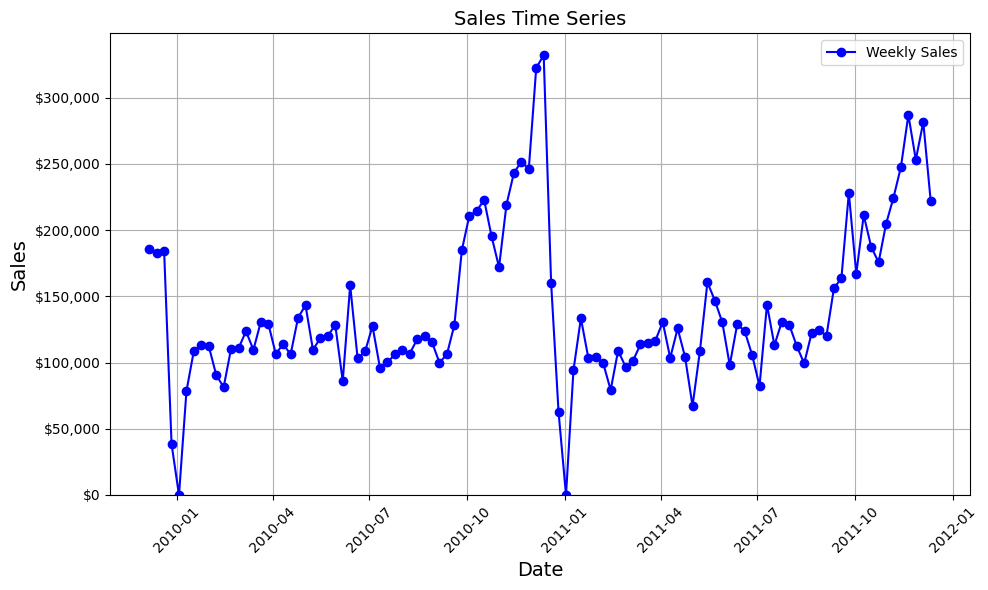

In [9]:
plot_df = outlier_capped_cust_out_removed_trx_data.copy()

# Set 'InvoiceDate' as the index
plot_df.set_index('InvoiceDate', inplace=True)

# Resample by week and sum the 'SKU_sales'
weekly_sales = plot_df['SKU_sales'].resample('W').sum().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(weekly_sales['InvoiceDate'], weekly_sales['SKU_sales'], label='Weekly Sales', color='blue', marker='o', linestyle='-')
plt.title("Sales Time Series", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Sales", fontsize=14)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Ensure y-axis displays integer values with dollar signs
ax = plt.gca()
ax.set_ylim(bottom=0)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${int(x):,}'))

plt.tight_layout()
plt.show()

This is the function the simulator uses to select test and control customers. 
Creates  test and control groups from customer sales data based on given pre-period sales.  Can create tests with a bias (ie test and control
    are significantly different, no bias, or tests with a lift within a range.  When creating biased tests, the software will draw random test and control
    until it finds a test that meets the required conditions.


In [10]:

def get_test(all_customers_sales_df: pd.DataFrame, 
             customers_df: pd.DataFrame, 
             pre_start_date: str, 
             pre_end_date: str, 
             bias: bool = True, 
             pos_bias: bool = True, 
             min_bias: float = 0.2, 
             max_bias: float = 0.01,  
             max_lift_selection: bool = False, 
             max_lift: float = 0.1, 
             num_test: int = 5000, 
             num_control: int = 5000, 
             max_attempts: int = 100) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Creates  test and control groups from customer sales data based on given pre-period sales.  Can create tests with a bias (ie test and control
    are significantly different, no bias, or tests with a lift within a range.  When creating biased tests, the software will draw random test and control
    until it finds a test that meets the required conditions.
    
    Args:
        all_customers_sales_df (pd.DataFrame): DataFrame containing all customer sales data.
        customers_df (pd.DataFrame): DataFrame containing customer pool for selection.
        pre_start_date (str): Start date for the pre-period.
        pre_end_date (str): End date for the pre-period.
        bias (bool): Whether to create a biased test group. Defaults to True.
        pos_bias (bool): Whether to create a positive bias. Defaults to True.
        min_bias (float): Minimum p-value for bias. Defaults to 0.2.
        max_bias (float): Maximum p-value for bias. Defaults to 0.01.
        max_lift_selection (bool): Whether to apply a maximum lift selection. Defaults to False
        max_lift (float): Maximum allowed lift. Defaults to 0.1.
        num_test (int): Number of test customers to select. Defaults to 5000.
        num_control (int): Number of control customers to select. Defaults to 5000.
        max_attempts (int): Maximum number of attempts to find a biased test group. Defaults to 100.
        
    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: DataFrames of test and control customer ids.
    """
    if bias and max_lift_selection:
        raise ValueError("Cannot create a test with both max_lift and bias")
    
    # Constants for column names
    CUSTOMER_ID_COL = 'Customer ID'
    INVOICE_DATE_COL = 'InvoiceDate'
    SKU_SALES_COL = 'SKU_sales'
    
    def create_random_test_groups(customers_df: pd.DataFrame, num_test: int, num_control: int) -> tuple[pd.DataFrame, pd.DataFrame]:
        test_df = customers_df.sample(n=num_test)
        control_df = customers_df.drop(test_df.index).sample(n=num_control)
        return test_df, control_df

    attempt = 0
    
    while attempt < max_attempts:
        attempt += 1
        
        # Filter the data for the pre-period
        pre_period_df = all_customers_sales_df[(all_customers_sales_df[INVOICE_DATE_COL] >= pre_start_date) & 
                                               (all_customers_sales_df[INVOICE_DATE_COL] <= pre_end_date)].copy()
        
        # Create random test and control groups
        test_df, control_df = create_random_test_groups(customers_df, num_test=num_test, num_control=num_control)
        
        # Filter the sales data for the test and control groups
        test_sales_df = pre_period_df[pre_period_df[CUSTOMER_ID_COL].isin(test_df[CUSTOMER_ID_COL])].copy()
        control_sales_df = pre_period_df[pre_period_df[CUSTOMER_ID_COL].isin(control_df[CUSTOMER_ID_COL])].copy()
        
        # Aggregate sales by customer
        test_sales_agg = test_sales_df.groupby(CUSTOMER_ID_COL, as_index=False)[SKU_SALES_COL].sum()
        control_sales_agg = control_sales_df.groupby(CUSTOMER_ID_COL, as_index=False)[SKU_SALES_COL].sum()

        # Merge the sales and customer dataframes
        test_sales_agg = pd.merge(test_df, test_sales_agg, on=CUSTOMER_ID_COL, how='left')
        control_sales_agg = pd.merge(control_df, control_sales_agg, on=CUSTOMER_ID_COL, how='left')

        # Fill missing sales with 0
        test_sales_agg[SKU_SALES_COL] = test_sales_agg[SKU_SALES_COL].fillna(0)
        control_sales_agg[SKU_SALES_COL] = control_sales_agg[SKU_SALES_COL].fillna(0)

        # Perform t-test to check for bias
        t_stat, p_value = stats.ttest_ind(test_sales_agg[SKU_SALES_COL], control_sales_agg[SKU_SALES_COL])
        
        # Calculate mean sales for test and control groups
        test_mean_sales = test_sales_agg[SKU_SALES_COL].mean()
        control_mean_sales = control_sales_agg[SKU_SALES_COL].mean()
        lift = abs((test_mean_sales - control_mean_sales) / control_mean_sales)
        
        # Check bias conditions
        if bias and ((pos_bias and test_mean_sales > control_mean_sales) or not pos_bias) and min_bias < p_value < max_bias:
            return test_df, control_df
        # Check max lift condition
        elif max_lift_selection and lift < max_lift:
            return test_df, control_df
        # Check non-biased condition
        elif not bias and not max_lift_selection:
            return test_df, control_df
        
    raise ValueError(f"Unable to find a biased test group within {max_attempts} attempts.")

Given a dataframe of customer IDs, will pull the sales per customers for the given period between start date and end date
Returns a sales dataframe.  

In [11]:
def cust_list_to_sales_per_cust(sales_df: pd.DataFrame, 
                                custs_df: pd.DataFrame, 
                                start_date: str, 
                                end_date: str) -> pd.DataFrame:
    """
    Computes total sales per customer within a specified date range.
    
    Args:
        sales_df (pd.DataFrame): DataFrame containing sales data.
        custs_df (pd.DataFrame): DataFrame containing customer information.
        start_date (str): Start date for the sales period (inclusive).
        end_date (str): End date for the sales period (inclusive).
        
    Returns:
        pd.DataFrame: DataFrame containing customers and their corresponding total sales within the specified period.
    """
    
    # Constants for column names
    INVOICE_DATE_COL = 'InvoiceDate'
    CUSTOMER_ID_COL = 'Customer ID'
    SKU_SALES_COL = 'SKU_sales'
    
    # Filter sales data within the specified date range
    sales_time_slice = sales_df[(sales_df[INVOICE_DATE_COL] >= start_date) & 
                                (sales_df[INVOICE_DATE_COL] <= end_date)].copy()
    
    # Filter sales data to include only the customers in custs_df
    sales_cust_time_slice = sales_time_slice[sales_time_slice[CUSTOMER_ID_COL].isin(custs_df[CUSTOMER_ID_COL])]
    
    # Aggregate sales by customer
    sales_df_summed = sales_cust_time_slice.groupby(CUSTOMER_ID_COL, as_index=False)[SKU_SALES_COL].sum()
    
    # Merge with the customer list to ensure all customers are included, even those with no sales
    sales_df_nullfill = pd.merge(custs_df, sales_df_summed, on=CUSTOMER_ID_COL, how='left')
    
    # Fill missing sales with 0
    sales_df_nullfill[SKU_SALES_COL] = sales_df_nullfill[SKU_SALES_COL].fillna(0)
    
    return sales_df_nullfill

This is similar to the sales per cust function, but it returns a dataframe with customer sales that includes transaction details and dates.

In [13]:
#get sales dataframe from a customer list
def cust_list_to_sales_df(sales_df: pd.DataFrame, 
                          custs_df: pd.DataFrame, 
                          start_date: str, 
                          end_date: str) -> pd.DataFrame:
    """
    Filters sales data for a specified list of customers within a given date range.
    
    Args:
        sales_df (pd.DataFrame): DataFrame containing sales data.
        custs_df (pd.DataFrame): DataFrame containing customer information.
        start_date (str): Start date for the sales period (inclusive).
        end_date (str): End date for the sales period (inclusive).
        
    Returns:
        pd.DataFrame: DataFrame containing sales data for the specified customers within the given date range.
    """
    
    # Constants for column names
    INVOICE_DATE_COL = 'InvoiceDate'
    CUSTOMER_ID_COL = 'Customer ID'
    
    # Filter sales data within the specified date range
    sales_time_slice = sales_df[(sales_df[INVOICE_DATE_COL] >= start_date) & 
                                (sales_df[INVOICE_DATE_COL] <= end_date)].copy()
    
    # Filter sales data to include only the customers in custs_df
    sales_cust_time_slice = sales_time_slice[sales_time_slice[CUSTOMER_ID_COL].isin(custs_df[CUSTOMER_ID_COL])]
    
    return sales_cust_time_slice

Measure a test, given sales dataframe, list of test and control customers, and timeframes for measurement

In [14]:
#measurement function
def measurement(sales_df: pd.DataFrame, 
                test_custs_df: pd.DataFrame, 
                control_custs_df: pd.DataFrame, 
                pre_start_date: pd.Timestamp, 
                pre_length: pd.Timedelta, 
                pre_post_buffer: pd.Timedelta, 
                post_length: pd.Timedelta) -> dict:
    """
    Measures the lift in sales between test and control groups before and after a specified period.
    
    Args:
        sales_df (pd.DataFrame): DataFrame containing sales data.
        test_custs_df (pd.DataFrame): DataFrame containing test customers.
        control_custs_df (pd.DataFrame): DataFrame containing control customers.
        pre_start_date (pd.Timestamp): Start date for the pre-period.
        pre_length (pd.Timedelta): Duration of the pre-period.
        pre_post_buffer (pd.Timedelta): Buffer period between pre and post periods.
        post_length (pd.Timedelta): Duration of the post-period.
        
    Returns:
        dict: Dictionary containing calculated lift and average sales values.
    """
    
    # Constants for column names
    SKU_SALES_COL = 'SKU_sales'
    
    # Calculate date ranges
    pre_end_date = pre_start_date + pre_length
    post_start_date = pre_end_date + pre_post_buffer
    post_end_date = post_start_date + post_length

    # Calculate sales for test and control groups during pre and post periods
    test_pre_values = cust_list_to_sales_per_cust(sales_df, test_custs_df, pre_start_date, pre_end_date)
    test_post_values = cust_list_to_sales_per_cust(sales_df, test_custs_df, post_start_date, post_end_date)
    control_pre_values = cust_list_to_sales_per_cust(sales_df, control_custs_df, pre_start_date, pre_end_date)
    control_post_values = cust_list_to_sales_per_cust(sales_df, control_custs_df, post_start_date, post_end_date)
    
    # Calculate average sales for test and control groups
    test_pre_avg = test_pre_values[SKU_SALES_COL].mean()
    test_post_avg = test_post_values[SKU_SALES_COL].mean()
    control_pre_avg = control_pre_values[SKU_SALES_COL].mean()
    control_post_avg = control_post_values[SKU_SALES_COL].mean()

    # Calculate lifts
    pre_lift = (test_pre_avg - control_pre_avg) / control_pre_avg * 100
    post_lift = (test_post_avg - control_post_avg) / control_post_avg * 100
    pre_post_expectation = control_post_avg / control_pre_avg * test_pre_avg
    pre_vs_post_lift = (test_post_avg - pre_post_expectation) / pre_post_expectation * 100

    # Perform t-tests to compare means between test and control groups
    t_stat_post, p_value_post = stats.ttest_ind(test_post_values[SKU_SALES_COL], control_post_values[SKU_SALES_COL])
    t_stat_pre, p_value_pre = stats.ttest_ind(test_pre_values[SKU_SALES_COL], control_pre_values[SKU_SALES_COL])

    # Compile results into a dictionary
    results_dictionary = {
        'pre_lift': pre_lift,
        'post_lift': post_lift,
        'pre_vs_post_lift': pre_vs_post_lift,
        'cntl_pre_avg': control_pre_avg,
        'cntl_post_avg': control_post_avg,
        'test_pre_avg': test_pre_avg,
        'test_post_avg': test_post_avg,
        'p_val_post': p_value_post,
        'p_val_pre': p_value_pre,
        'pre_start_date': pre_start_date
    }

    # Print and return results
    #print(results_dictionary)
    return results_dictionary

This is the main engine used to run simulations 

In [16]:
#unbiased tests

#main program - biased tests

#set the test parameters
test_cust_count = 1000
control_cust_count = 1000
pre_days = 90
post_days = 90
time_between_pre_post = 0
simulations_count = 1000

#make dataframes of the available customers and dates
sales_df = outlier_capped_trx_data.copy()
customers_df = pd.DataFrame(sales_df['Customer ID'].unique(), columns=['Customer ID'])
dates_df = pd.DataFrame(sales_df['InvoiceDate'].unique(), columns=['InvoiceDate']).sort_values(by='InvoiceDate')

#change the day counts into time format
pre_post_buffer = timedelta(days=time_between_pre_post)
pre_length = timedelta(days=pre_days)
post_length = timedelta(days=post_days)

#figure out what are the viable dates to simulate
min_pre_start = dates_df['InvoiceDate'].min() 
max_pre_start = dates_df['InvoiceDate'].max() - pre_length - post_length - pre_post_buffer
viable_pre_start_df = dates_df[(dates_df['InvoiceDate'] > min_pre_start) & (dates_df['InvoiceDate'] < max_pre_start)]

#list of measurements from the simulation
results_list_baseline = []
results_list_lift_limited_20 = []
results_list_lift_limited_10 = []
results_list_lift_limited_05 = []
results_list_lift_limited_01 = []

#simulation runs
for i in range(0,simulations_count):
    print(f"iteration: {i}")
    #select a random date from the available dates
    pre_start_date = viable_pre_start_df.sample(1, replace=True).iloc[0, 0]

    #align the pre and post start and end with the random pre start date
    pre_end_date = pre_start_date + pre_length
    post_start_date = pre_start_date + pre_length + pre_post_buffer
    post_end_date = pre_start_date + pre_length + pre_post_buffer + post_length

    #select test and control randomly
    test_custs_df, control_custs_df = get_test(sales_df, customers_df, pre_start_date, pre_end_date, bias=False, pos_bias=False, min_bias=0, max_bias=0.0, max_lift_selection=False, max_lift=0.0, num_test=test_cust_count, num_control=control_cust_count, max_attempts=500)

    #test and control measures append to tracking mechanism
    results_baseline = measurement(sales_df, test_custs_df, control_custs_df, pre_start_date, pre_length, pre_post_buffer, post_length)
    results_list_baseline.append(results_baseline)

    #select test and control randomly, but below 20% pre period lift
    test_custs_df, control_custs_df = get_test(sales_df, customers_df, pre_start_date, pre_end_date, bias=False, pos_bias=False, min_bias=0, max_bias=0.0, max_lift_selection=True, max_lift=0.2, num_test=test_cust_count, num_control=control_cust_count, max_attempts=500)

    #test and control measures  append to tracking mechanism
    results_lift_limited_20 = measurement(sales_df, test_custs_df, control_custs_df, pre_start_date, pre_length, pre_post_buffer, post_length)
    results_list_lift_limited_20.append(results_lift_limited_20)

    #select test and control randomly, but below 10% pre period lift
    test_custs_df, control_custs_df = get_test(sales_df, customers_df, pre_start_date, pre_end_date, bias=False, pos_bias=False, min_bias=0, max_bias=0.0, max_lift_selection=True, max_lift=0.1, num_test=test_cust_count, num_control=control_cust_count, max_attempts=500)

    #test and control measures  append to tracking mechanism
    results_lift_limited_10 = measurement(sales_df, test_custs_df, control_custs_df, pre_start_date, pre_length, pre_post_buffer, post_length)
    results_list_lift_limited_10.append(results_lift_limited_10)

    #select test and control randomly, but below 5% pre period lift
    test_custs_df, control_custs_df = get_test(sales_df, customers_df, pre_start_date, pre_end_date, bias=False, pos_bias=False, min_bias=0, max_bias=0.0, max_lift_selection=True, max_lift=0.05, num_test=test_cust_count, num_control=control_cust_count, max_attempts=1000)

    #test and control measures  append to tracking mechanism
    results_lift_limited_05 = measurement(sales_df, test_custs_df, control_custs_df, pre_start_date, pre_length, pre_post_buffer, post_length)
    results_list_lift_limited_05.append(results_lift_limited_05)

    #select test and control randomly, but below 1% pre period lift
    test_custs_df, control_custs_df = get_test(sales_df, customers_df, pre_start_date, pre_end_date, bias=False, pos_bias=False, min_bias=0, max_bias=0.0, max_lift_selection=True, max_lift=0.01, num_test=test_cust_count, num_control=control_cust_count, max_attempts=1500)

    #test and control measures  append to tracking mechanism
    results_lift_limited_01 = measurement(sales_df, test_custs_df, control_custs_df, pre_start_date, pre_length, pre_post_buffer, post_length)
    results_list_lift_limited_01.append(results_lift_limited_01)

#put all of the result lists into dataframes
results_df_baseline = pd.DataFrame(results_list_baseline)
results_df_lift_limited_20 = pd.DataFrame(results_list_lift_limited_20) 
results_df_lift_limited_10 = pd.DataFrame(results_list_lift_limited_10)
results_df_lift_limited_05 = pd.DataFrame(results_list_lift_limited_05)
results_df_lift_limited_01 = pd.DataFrame(results_list_lift_limited_01)



iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
it

A function to create a histogram of the test results

In [56]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def histogram_lift(results_df, metric_string, version):
    # Cust trx counts
    stdev_index = results_df[metric_string].std()
    print(f"stdev: {stdev_index}")
    mean = results_df[metric_string].mean()

    # Plotting the histogram of outlier index
    plt.figure(figsize=(10, 6))
    plt.hist(results_df[metric_string], bins=30, color=(0.1, 0.2, 0.7, 0.6), edgecolor='black', alpha=0.7)

    plt.axvline(stdev_index + 0, color='magenta', linestyle='--', linewidth=2, label=f'1 st dev above 0%, {stdev_index + 0:,.1f}%')
    plt.axvline(-stdev_index + 0, color='magenta', linestyle='--', linewidth=2, label=f'1 st dev below 0% {-stdev_index + 0:,.1f}%')
    plt.axvline(mean, color='gray', linewidth=2, linestyle='--', label=f'mean {mean:,.2f}%')
    plt.axvline(0, color='Black', linewidth=3, label='0% Lift')
    plt.title(f"Histogram of {version}", fontsize=13)
    plt.xlabel("Lift %", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend()

    # Adjust grid to make it less obvious
    plt.grid(True, which='both', linestyle='--', color='black', linewidth=0.5, alpha=0.0)

    # Format the x-axis to show percentage signs
    ax = plt.gca()
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}%'))

    plt.tight_layout()
    plt.show()

Histograms for pre period test vs control sales, testing period test vs control, and diff in diff test vs control sales

stdev: 20.570543104195757


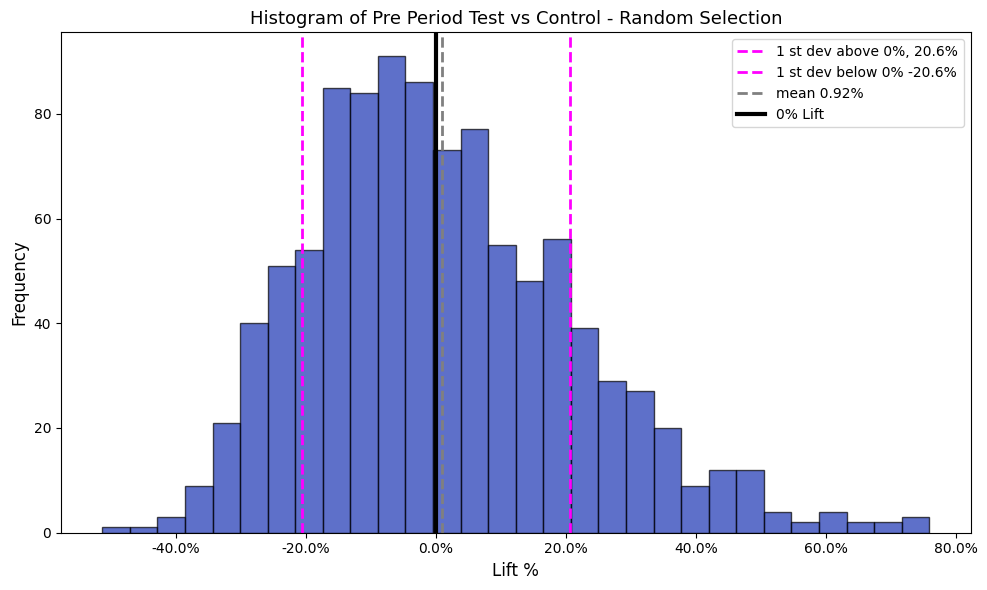

stdev: 19.923751235722644


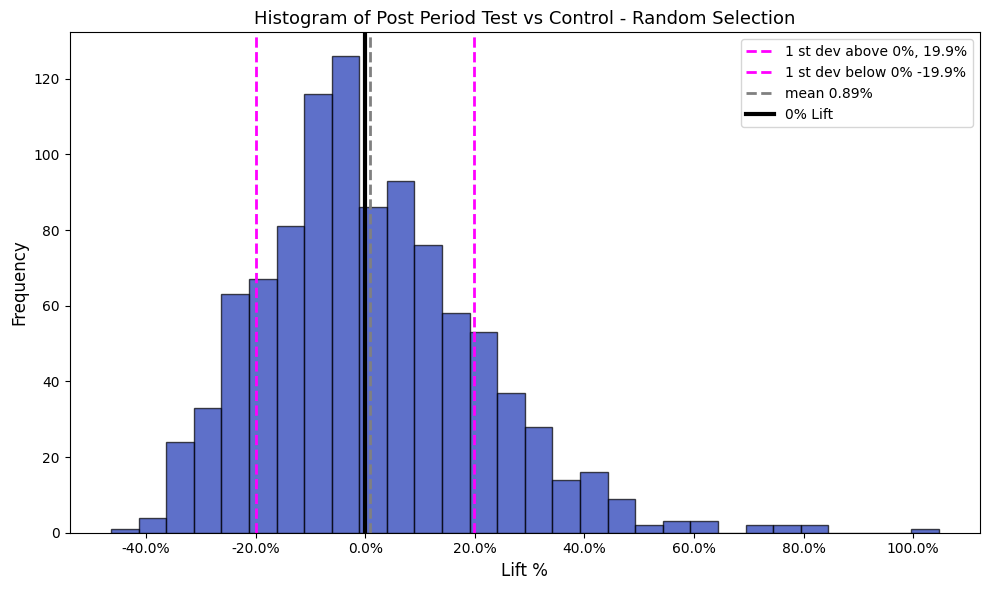

stdev: 13.567435062841444


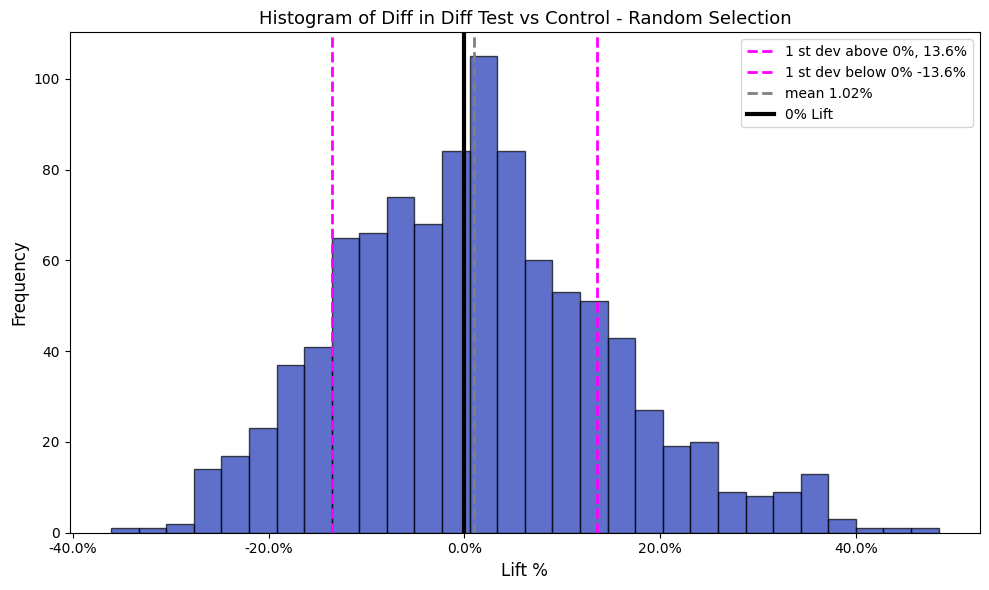

stdev: 8.520774971893099


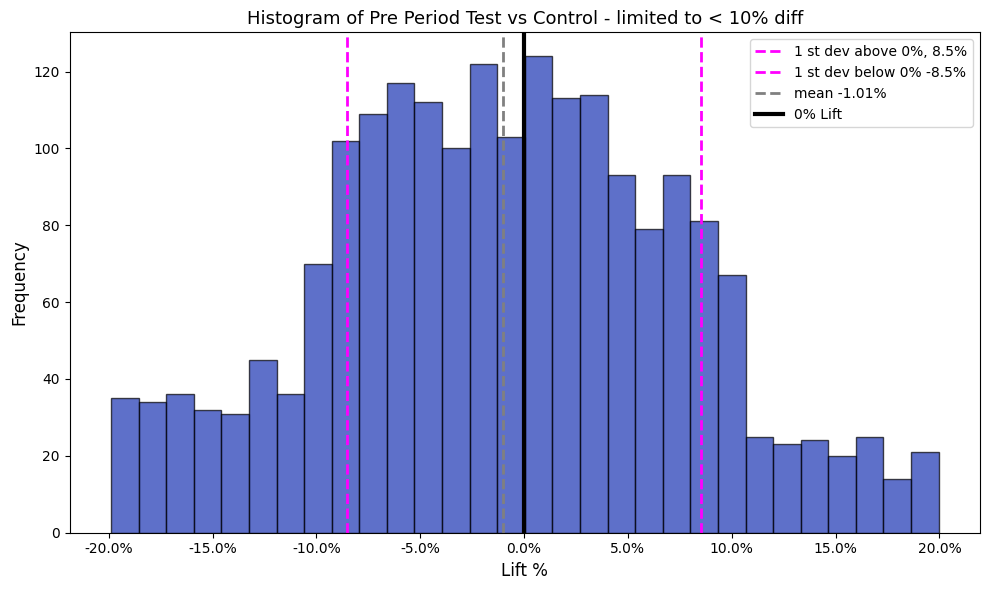

stdev: 13.92726861538038


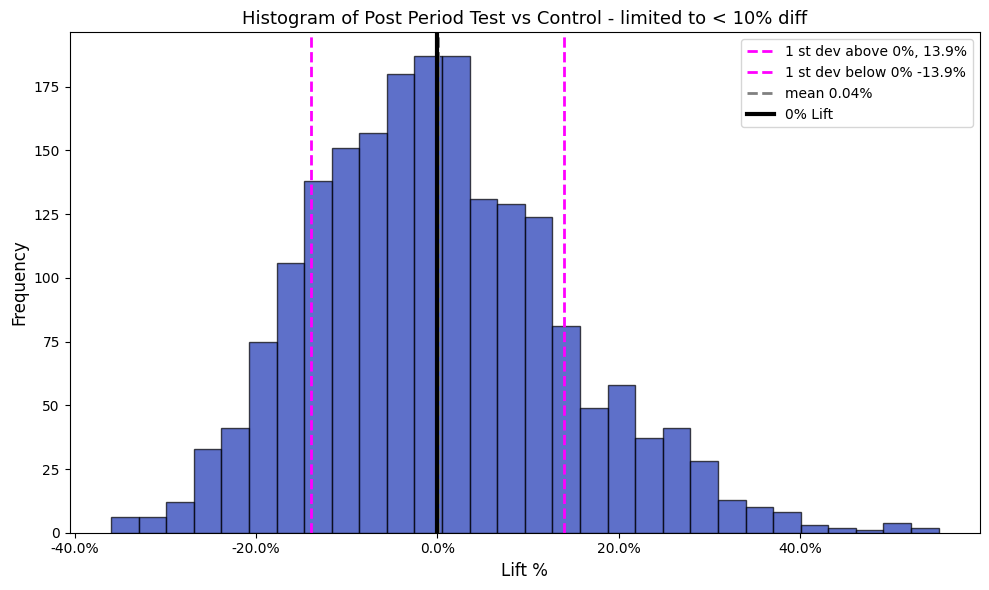

stdev: 12.477503747012102


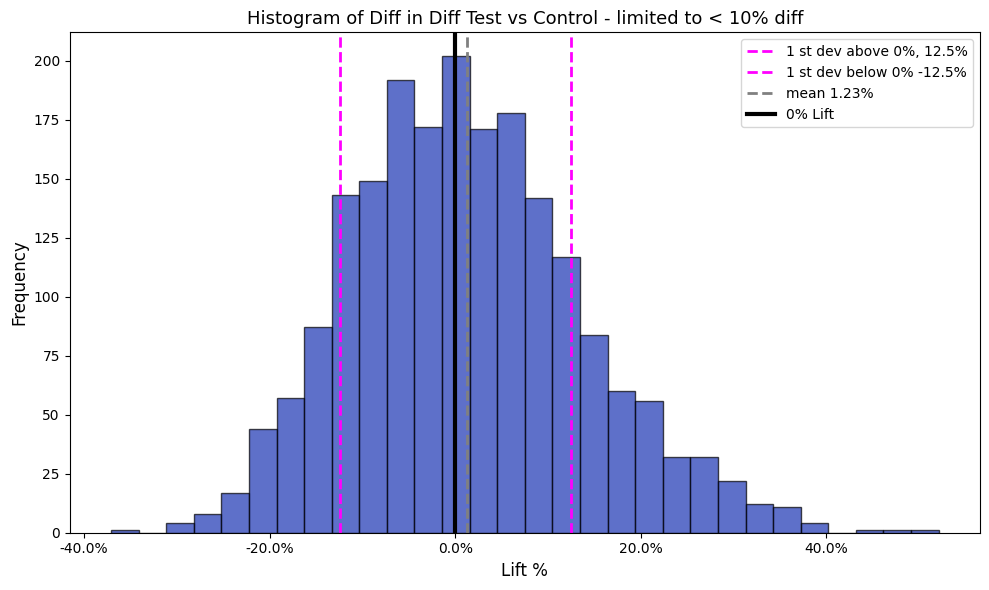

stdev: 2.930326722352439


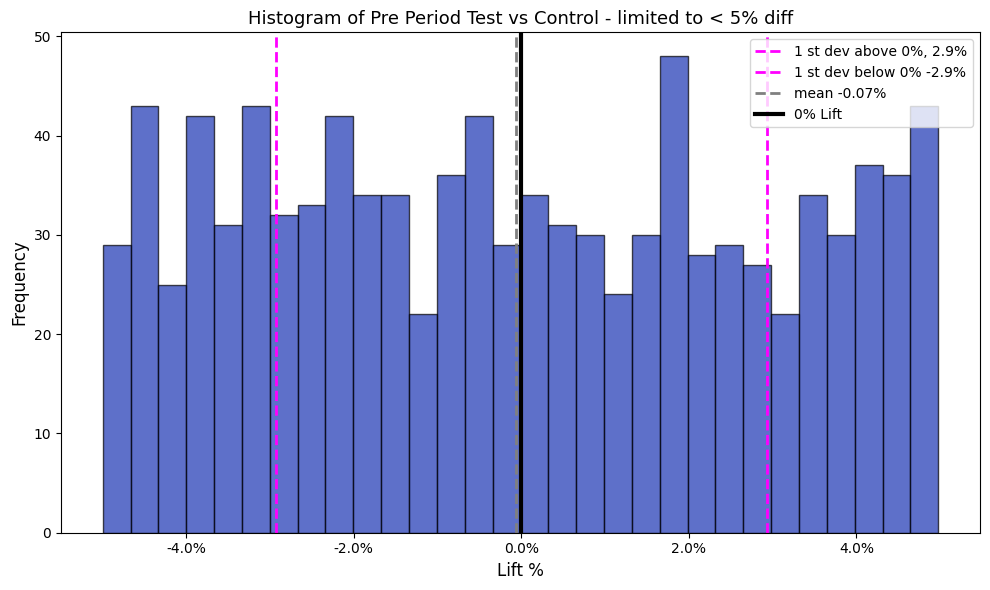

stdev: 12.940049283434988


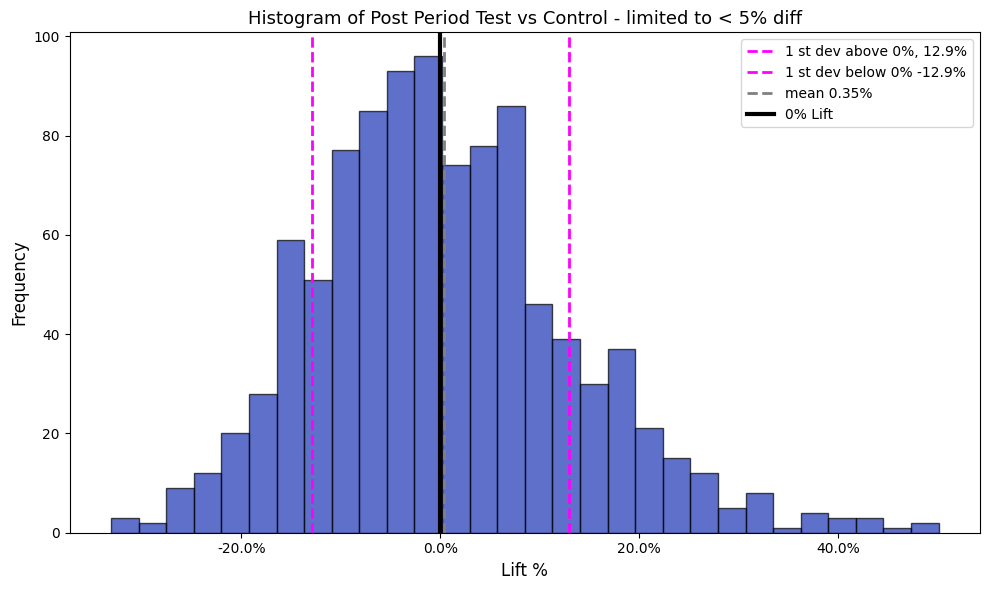

stdev: 12.502324451022822


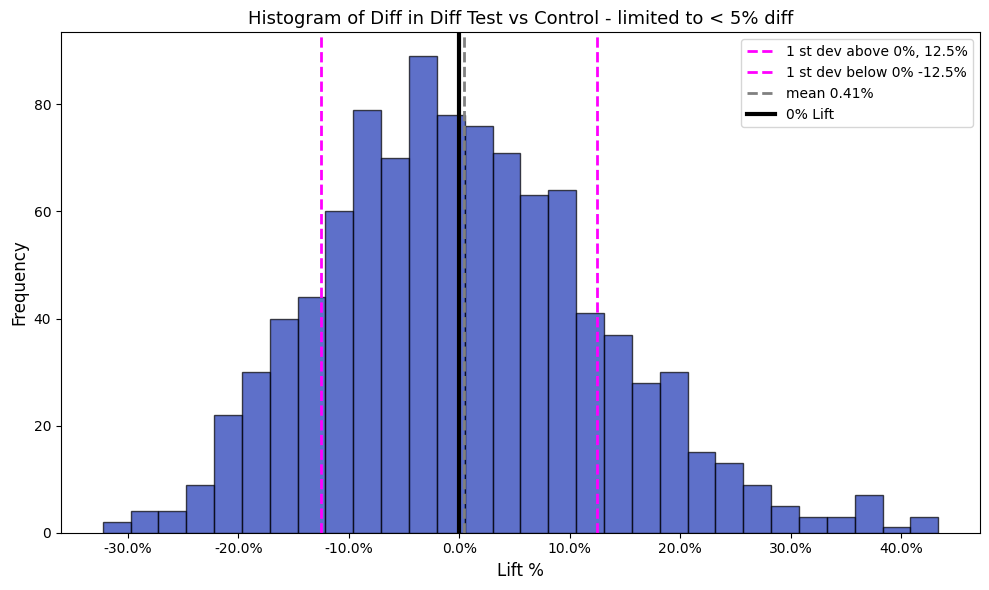

stdev: 0.5740215704866956


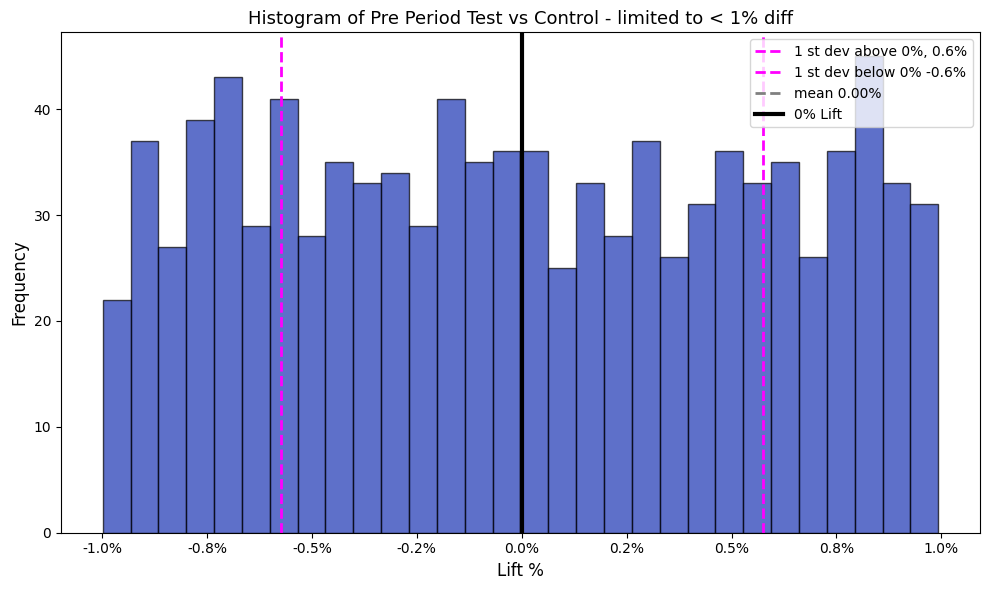

stdev: 12.0786813851898


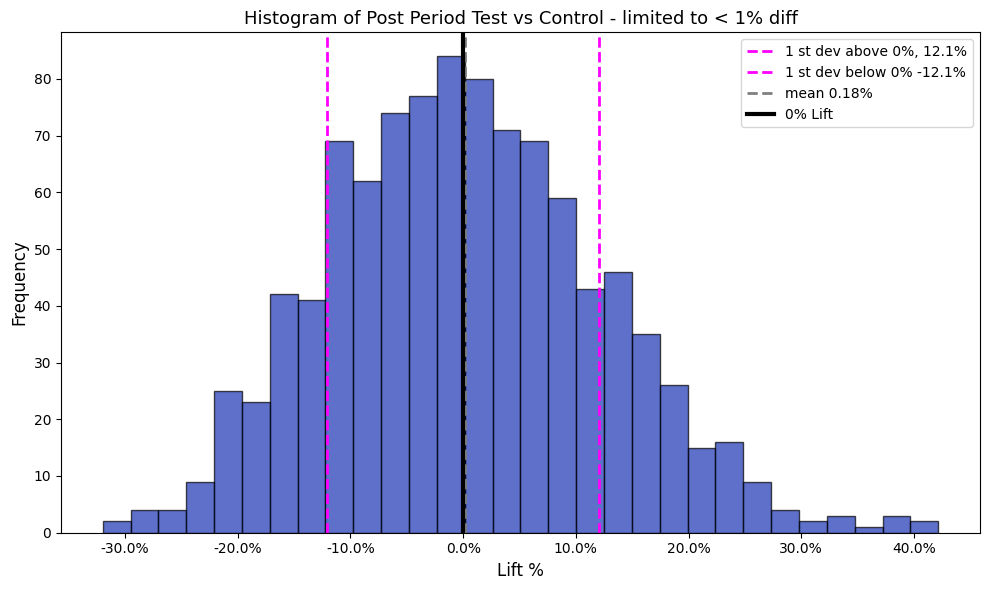

stdev: 12.095725764397416


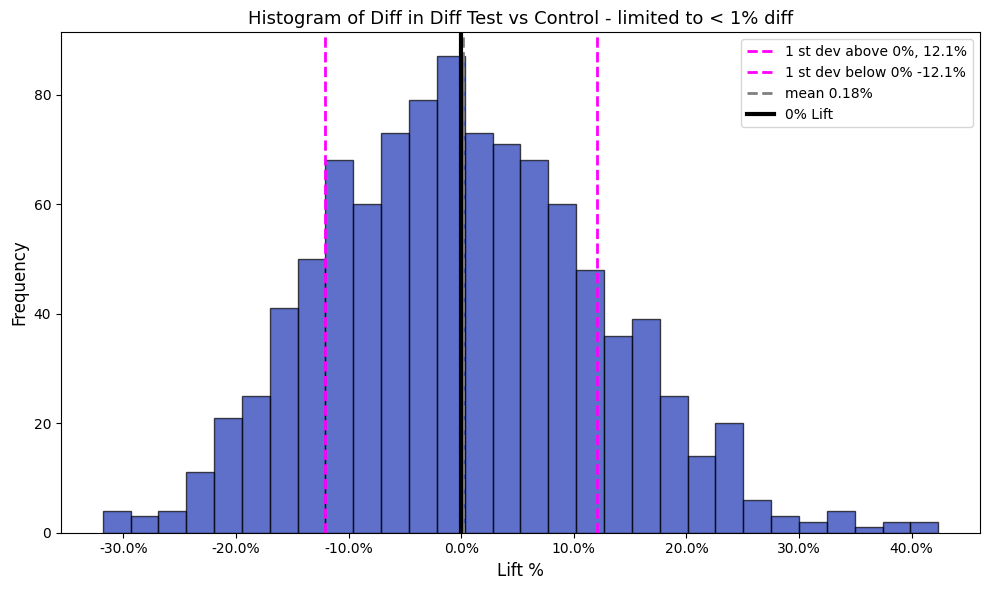

In [57]:
#cust trx counts
histogram_lift(results_df_baseline, 'pre_lift', 'Pre Period Test vs Control - Random Selection')
histogram_lift(results_df_baseline, 'post_lift', 'Post Period Test vs Control - Random Selection')
histogram_lift(results_df_baseline, 'pre_vs_post_lift', 'Diff in Diff Test vs Control - Random Selection')

#histogram_lift(results_df_lift_limited_20, 'pre_lift', 'Pre Period Test vs Control - limited to < 20% diff')
#histogram_lift(results_df_lift_limited_20, 'post_lift', 'Post Period Test vs Control - limited to < 20% diff')
#histogram_lift(results_df_lift_limited_20, 'pre_vs_post_lift', 'Diff in Diff Test vs Control - limited to < 20% diff')

histogram_lift(results_df_lift_limited_10, 'pre_lift', 'Pre Period Test vs Control - limited to < 10% diff')
histogram_lift(results_df_lift_limited_10, 'post_lift', 'Post Period Test vs Control - limited to < 10% diff')
histogram_lift(results_df_lift_limited_10, 'pre_vs_post_lift', 'Diff in Diff Test vs Control - limited to < 10% diff')

histogram_lift(results_df_lift_limited_05, 'pre_lift', 'Pre Period Test vs Control - limited to < 5% diff')
histogram_lift(results_df_lift_limited_05, 'post_lift', 'Post Period Test vs Control - limited to < 5% diff')
histogram_lift(results_df_lift_limited_05, 'pre_vs_post_lift', 'Diff in Diff Test vs Control - limited to < 5% diff')

histogram_lift(results_df_lift_limited_01, 'pre_lift', 'Pre Period Test vs Control - limited to < 1% diff')
histogram_lift(results_df_lift_limited_01, 'post_lift', 'Post Period Test vs Control - limited to < 1% diff')
histogram_lift(results_df_lift_limited_01, 'pre_vs_post_lift', 'Diff in Diff Test vs Control - limited to < 1% diff')





In [63]:
#statistics from the null tests

#correlation of pre period and post period lift
correl_result = stats.pearsonr(results_df_baseline['pre_lift'], results_df_baseline['post_lift'])[0]
print("The correlation between pre and post lift is:", correl_result)     

# of results >40%
print(f" count of results > 40% lift {results_df_baseline['post_lift'].loc[abs(results_df_baseline['post_lift']) > 40.0].count()}")

# of results >40%
print(f" count of results > 40% lift {results_df_baseline['pre_vs_post_lift'].loc[abs(results_df_baseline['pre_vs_post_lift']) > 40.0].count()}")

# of results >40%
print(f" count of results > 40% lift {results_df_lift_limited_01['post_lift'].loc[abs(results_df_lift_limited_01['post_lift']) > 40.0].count()}")


The correlation between pre and post lift is: 0.7734845510532378
 count of results > 40% lift 40
 count of results > 40% lift 3
 count of results > 40% lift 2


Save the results dataframes to file..

In [64]:
filepath = Path(f'/Users/jeffreycampbell/Desktop/python_work/customer_loyalty/results_df_baseline.csv') 
results_df_baseline.to_csv(filepath, index=False)
filepath = Path(f'/Users/jeffreycampbell/Desktop/python_work/customer_loyalty/results_df_lift_limited_01.csv') 
results_df_lift_limited_01.to_csv(filepath, index=False)
